In [1]:
import os, sys, glob
import re
from datetime import datetime, timedelta,date
import pandas as pd
from IPython.display import display
import xarray as xr
from matplotlib import dates as mdates

from scipy import stats
from scipy.stats import multivariate_normal
import seaborn as sns

import learning_lidar.generation.generate_density_utils as gen_den_utils
import learning_lidar.generation.generation_utils as gen_utils
import learning_lidar.preprocessing.preprocessing_utils as prep_utils
from learning_lidar.generation.KDE_estimation_sample import kde_estimation_main
from learning_lidar.generation.generate_LC_pattern import generate_LC_pattern_main
import learning_lidar.generation.generate_bg_signals_utils as gen_bg_utils
from learning_lidar.utils import utils, xr_utils, vis_utils, proc_utils, global_settings as gs
vis_utils.set_visualization_settings()
TIMEFORMAT = mdates.DateFormatter(r'%H')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from pytictoc import TicToc
import sklearn
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import learning_lidar.dataseting.dataseting_utils as ds_utils
# Define simple gaussian
def gauss_function(x, amp, x0, sigma):
    return amp * np.exp(-(x - x0) ** 2. / (2. * sigma ** 2.))

In [2]:
def plot_daily_profile_for_Opex(profile_ds, height_slice=None, figsize=(15, 5),
                                save_fig=False, threshold=None, cbar_text=None,
                                folder_name:os.path = None, format_fig:str='png'):
    wavelengths = profile_ds.Wavelength.values
    if height_slice is None:
        height_slice = slice(profile_ds.Height[0].values, profile_ds.Height[-1].values)
    str_date = profile_ds.Time[0].dt.strftime("%Y-%m-%d").values.tolist()
    ncols = wavelengths.size
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize, sharey=True)
    if ncols > 1:
        for col_index, (wavelength, ax) in enumerate(zip(wavelengths, axes.ravel())):
            ds = profile_ds.sel(Height=height_slice, Wavelength=wavelength)
            # try:
            #     ds.attrs['units'] = ds.attrs['units'].replace("km", r"\textbf{km}")
            # except Exception as e:
            #     print(e)
            ds.Height.attrs['units'] = ds.Height.attrs['units'].replace("km", r"\textbf{km}")

            if threshold is None:
                threshold = ds.max()
                if not (isinstance(threshold, int) or isinstance(threshold, float) ):
                    threshold = threshold.values
                    #print(threshold)
            ds = xr.DataArray.clip(ds, max=threshold, keep_attrs=True)
            # ds = ds.where(ds<threshold)
            if col_index == 0:
                cbar_ax = fig.add_axes([.91, .15, .03, .7])

            ds.plot(cmap='turbo', ax=ax, vmin=0, vmax=threshold, cbar_ax=cbar_ax,zorder=-20)
            ax.set_rasterization_zorder(-10)
            ax.xaxis.set_major_formatter(TIMEFORMAT)
            ax.xaxis.set_tick_params(rotation=0)
            ax.set_title("")
            ax.set_ylabel(ax.get_ylabel().replace("Height", r'\textbf{Height}'))
            ax.set_xlabel(ax.get_xlabel().replace("Time", r'\textbf{Time}'))
            for tick in ax.xaxis.get_majorticklabels():
                tick.set_horizontalalignment("left")
            if col_index != 0:
                ax.yaxis.label.set_visible(False)
    else:
        ax = axes
        ds = profile_ds.sel(Height=height_slice)
        # try:
        #     ds.attrs['units'] = ds.attrs['units'].replace("km", r"\textbf{km}")
        # except Exception as e:
        #     print(e)
        ds.Height.attrs['units'] = ds.Height.attrs['units'].replace("km", r"\textbf{km}")
        cbar_ax = fig.add_axes([.91, .15, .03, .7])
        if threshold is None:
            threshold = ds.max()
            if not (isinstance(threshold, int) or isinstance(threshold, float) ):
                threshold = threshold.values
                #print(threshold)
                ds = xr.DataArray.clip(ds, max=threshold, keep_attrs=True)

        ds.plot(cmap='turbo', ax=ax,vmin=0, vmax=threshold, cbar_ax=cbar_ax, zorder=-20)
        ax.set_rasterization_zorder(-10)
        ax.xaxis.set_major_formatter(TIMEFORMAT)
        ax.xaxis.set_tick_params(rotation=0)
        ax.set_title("")
        ax.set_ylabel(ax.get_ylabel().replace("Height", r'\textbf{Height}'))
        ax.set_xlabel(ax.get_xlabel().replace("Time", r'\textbf{Time}'))
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("left")

    if cbar_text:
        cbar_ax.set_ylabel(cbar_text)

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    if ncols > 1:
        fig.tight_layout(rect=[0, 0, .9, 1])
    else:
        fig.tight_layout(rect=[0, 0, .87, 1])
    if save_fig:
        if folder_name is None:
             folder_name = os.path.join(os.path.abspath(os.path.curdir),'figures')
        suptitle = f"{profile_ds.info} - {str_date}"
        fig_path = vis_utils.save_fig(fig, fig_name=suptitle,
                                   folder_name=folder_name,
                                   format_fig=format_fig)
    else:
        fig_path=None
    plt.show()
    return fig_path, fig, axes

In [3]:
def daily_backscatter_from_profiles(day_date:datetime, station:gs.Station, wavelength:int=532, df_calib:pd.DataFrame=None):

    # set daily_datset_df.
    # If df_calib is None, then generate a dataframe from TROPOS data at level1a
    if df_calib is None:
        profiles_paths = prep_utils.get_TROPOS_dataset_paths(station, day_date, file_type= 'profiles',level = 'level1a')
        profiles_paths.sort()
        format_filename = r"(.*)_(.*)_TROPOS_(.*)_(.*)_(.*)_profiles.nc"
        format_times= ["%Y_%m_%d","%a", "%H_%M_%S", "%H%M", "%H%M"]
        time_stamps = [prep_utils.extract_date_time(path,format_filename, format_times) for path in profiles_paths]
        timestamps_df = pd.DataFrame(time_stamps,profiles_paths, columns=['dt_day', 'day','raw_time','start_time','end_time' ])
        daily_datset_df = timestamps_df.apply(lambda row: [row['dt_day'].date(),
                                       datetime.combine(date = row['dt_day'].date(),time=row['raw_time'].time()),
                                       datetime.combine(date = row['dt_day'].date(),time=row['start_time'].time()),
                                       datetime.combine(date = row['dt_day'].date(),time=row['end_time'].time())] ,
                          axis=1, result_type='expand').set_axis(['date','raw_time', 'start_time_period', 'end_time_period'], axis=1).\
            reset_index().rename(columns={'index':'profile_path'}).sort_values(by='start_time_period',ascending=True,ignore_index=True)
    else:
        daily_datset_df =  df_calib.loc[(df_calib['wavelength']==wavelength) & (pd.to_datetime(df_calib['date'])==day_date)].\
            sort_values(by='start_time_period',ascending=True,ignore_index=True)

    def _calc_mid_time(row):
        # Set time of profile to the center of the time slice
        dt_start = datetime.strptime(str(row['start_time_period']),'%Y-%m-%d %H:%M:%S')
        dt_end = datetime.strptime(str(row['end_time_period']),'%Y-%m-%d %H:%M:%S')
        dt_mid = dt_start+0.5*(dt_end-dt_start)
        round_seconds = timedelta(seconds=dt_mid.second % 30) # round according to time resolution of TROPOS
        dt_mid +=round_seconds
        return  dt_mid


    daily_datset_df ['mid_time_period'] =daily_datset_df.apply(lambda row:_calc_mid_time(row),axis=1, result_type='expand')
    #display(daily_datset_df)

    ## % initialize dataset of daily_beta_chan (xr.DataSet)
    heightIndx = station.get_height_bins_values()
    timeIndx = station.calc_daily_time_index(day_date)
    height_units = 'km'

    daily_beta_chan = xr.Dataset(data_vars={'beta': (('Height', 'Time','Wavelength'),
                                                     np.empty((heightIndx.shape[0], timeIndx.shape[0],1)))},
                                coords={'Height':heightIndx,'Time':timeIndx,'Wavelength': [wavelength]})
    daily_beta_chan.beta.attrs = {'long_name': r'$\beta $',
                                  'units': r'$\rm \frac{1}{km \cdot sr}$',
                                  'info': "Daily estimated aerosol backscatter by PollyNet Processing Chain, Tropos",
                                  'source_data': 'level1a',
                                  }
    daily_beta_chan.attrs = {'location':station.location}

    ## set attributes of coordinates
    daily_beta_chan.Height.attrs = {'units': fr'$\rm {height_units}$',
                                    'info': 'Measurements heights above sea level'}
    daily_beta_chan.Wavelength.attrs = {'long_name': r'$\lambda$', 'units': r'$\rm nm$'}
    daily_beta_chan = daily_beta_chan.transpose('Wavelength', 'Height', 'Time')
    daily_beta_chan['date'] = day_date

    ## Loading beta profiles and save into  daily_beta_chan
    Pollynet_key = f'aerBsc_klett_{wavelength}'
    valids = []
    print(f"Loading data from {day_date.strftime('%Y-%m-%d')} at {wavelength}...")
    for profile_name,dt_mid in zip(daily_datset_df.profile_path,daily_datset_df.mid_time_period):
        # Load profile
        pollynet_da = xr_utils.load_dataset(profile_name)
        profile = pollynet_da[Pollynet_key].values
        if np.isnan(profile).all():
            valids.append(False)
            continue

        #print([profile is None])
        valids.append(True)
        daily_beta_chan.beta.loc[dict(Time = dt_mid)]=profile

    # Filter valid times
    daily_datset_df['valid'] = valids

    print(f"Done loading data.")

    # Convert from 1/(mr sr) to 1/(km sr)
    daily_beta_chan = prep_utils.convert_profiles_units(daily_beta_chan)
    return daily_beta_chan, daily_datset_df

# Analyse finer PollyNet retrievals
### 1. Load calibration csv from TROPOS or Extract profiles data required for analysis

In [4]:
station_name='haifa'
station = gs.Station(station_name)
day_date = datetime(2017,10,2)
daily_times = station.calc_daily_time_index(day_date)
wavelength = 532
TGRS_folder = r'C:\Users\addalin\Dropbox\Lidar\Adi_TGRS'
figs_folder = os.path.join(TGRS_folder,'figures')
name_str = f"TGRS_TROPOS_{day_date.strftime('%Y-%m-%d')}_profiles"
table_name = name_str+"_info.csv"
profiles_ds_name = name_str+".nc"
GEN_PROFILES = False # True - crate and save the profiles; False - upload previous generated data
SAVE_FIG = False
LOAD_CLIB_CSV = False
FORMAT_FIG = 'jpg' # 'svg'
max_height = 15 # km
height_slice=slice(0,max_height)


if GEN_PROFILES:
    if LOAD_CLIB_CSV:
        # Load calibration dataset # Extract the data parameters of the data from pollynet '+lidar_calibration_constant.csv'
        pollynet_calib_path = 'pollyxt_tropos_calibration_lidar_calibration_constant.csv'
        polly_calib = pd.read_csv(os.path.join(TGRS_folder, pollynet_calib_path))
        polly_calib['cali_start_time']= pd.to_datetime(polly_calib['cali_start_time'])
        polly_calib['cali_stop_time']= pd.to_datetime(polly_calib['cali_stop_time'])
        polly_calib['date'] = polly_calib['cali_start_time'].dt.date
        method = 'Klett_Method'
        telescope = 'far_range'
        df_calib =  polly_calib[polly_calib.date == day_date.date()][polly_calib.wavelength ==wavelength][polly_calib.telescope==telescope][polly_calib.cali_method==method]
        df_calib = ds_utils.add_profiles_values(df_calib, station, day_date, file_type='profiles')
        df_calib = df_calib.rename({'liconst': 'LC', 'uncertainty_liconst': 'LC_std', 'matched_nc_profile': 'profile_path',
                   'cali_start_time':'start_time_period','cali_stop_time':'end_time_period'},
                            axis='columns')
        display(df_calib)
    else:
        # Extract profiles data
        df_calib = None
    daily_beta_chan, daily_datset_df = daily_backscatter_from_profiles(day_date=day_date, station=station, df_calib=df_calib, wavelength=532)

    # save profiles info and values
    xr_utils.save_dataset(dataset=daily_beta_chan,folder_name=TGRS_folder,nc_name=profiles_ds_name)
    daily_datset_df.to_csv(os.path.join(TGRS_folder,table_name))
else:
    # upload profiles info and values
    daily_beta_chan = xr_utils.load_dataset(os.path.join(TGRS_folder,profiles_ds_name))
    daily_datset_df = pd.read_csv(os.path.join(TGRS_folder,table_name))

valid_times = [datetime.strptime(str(t),'%Y-%m-%d %H:%M:%S') for t in daily_datset_df[daily_datset_df['valid']]['mid_time_period']]


In [5]:
daily_beta_chan

<xarray.Dataset>
Dimensions:      (Time: 2880, Wavelength: 1, Height: 3000)
Coordinates:
  * Time         (Time) datetime64[ns] 2017-10-02 ... 2017-10-02T23:59:30
  * Height       (Height) float64 0.07875 0.08622 0.09369 ... 22.47 22.48 22.49
  * Wavelength   (Wavelength) int32 532
Data variables:
    beta         (Wavelength, Height, Time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    date         datetime64[ns] 2017-10-02
    beta_ratio   (Wavelength, Height, Time) float32 nan nan nan ... nan nan nan
    ratio        (Wavelength, Height, Time) float32 nan nan nan ... nan nan nan
    interp_beta  (Wavelength, Height, Time) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    location:  Haifa

In [6]:
if LOAD_CLIB_CSV:
    da = polly_calib.set_index(['cali_start_time','wavelength','cali_method','id']).to_xarray()
    time_slice= slice(day_date,day_date+timedelta(hours=24))
    da.sel(wavelength=wavelength, cali_start_time=time_slice).plot.scatter(y='liconst' ,x = 'cali_start_time', hue='cali_method', figsize=(15,7), s=2)
    plt.show()

### 4. Show daily aerosol coefficients

C:\Users\addalin\AppData\Local\Temp\ipykernel_6140\1513445115.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


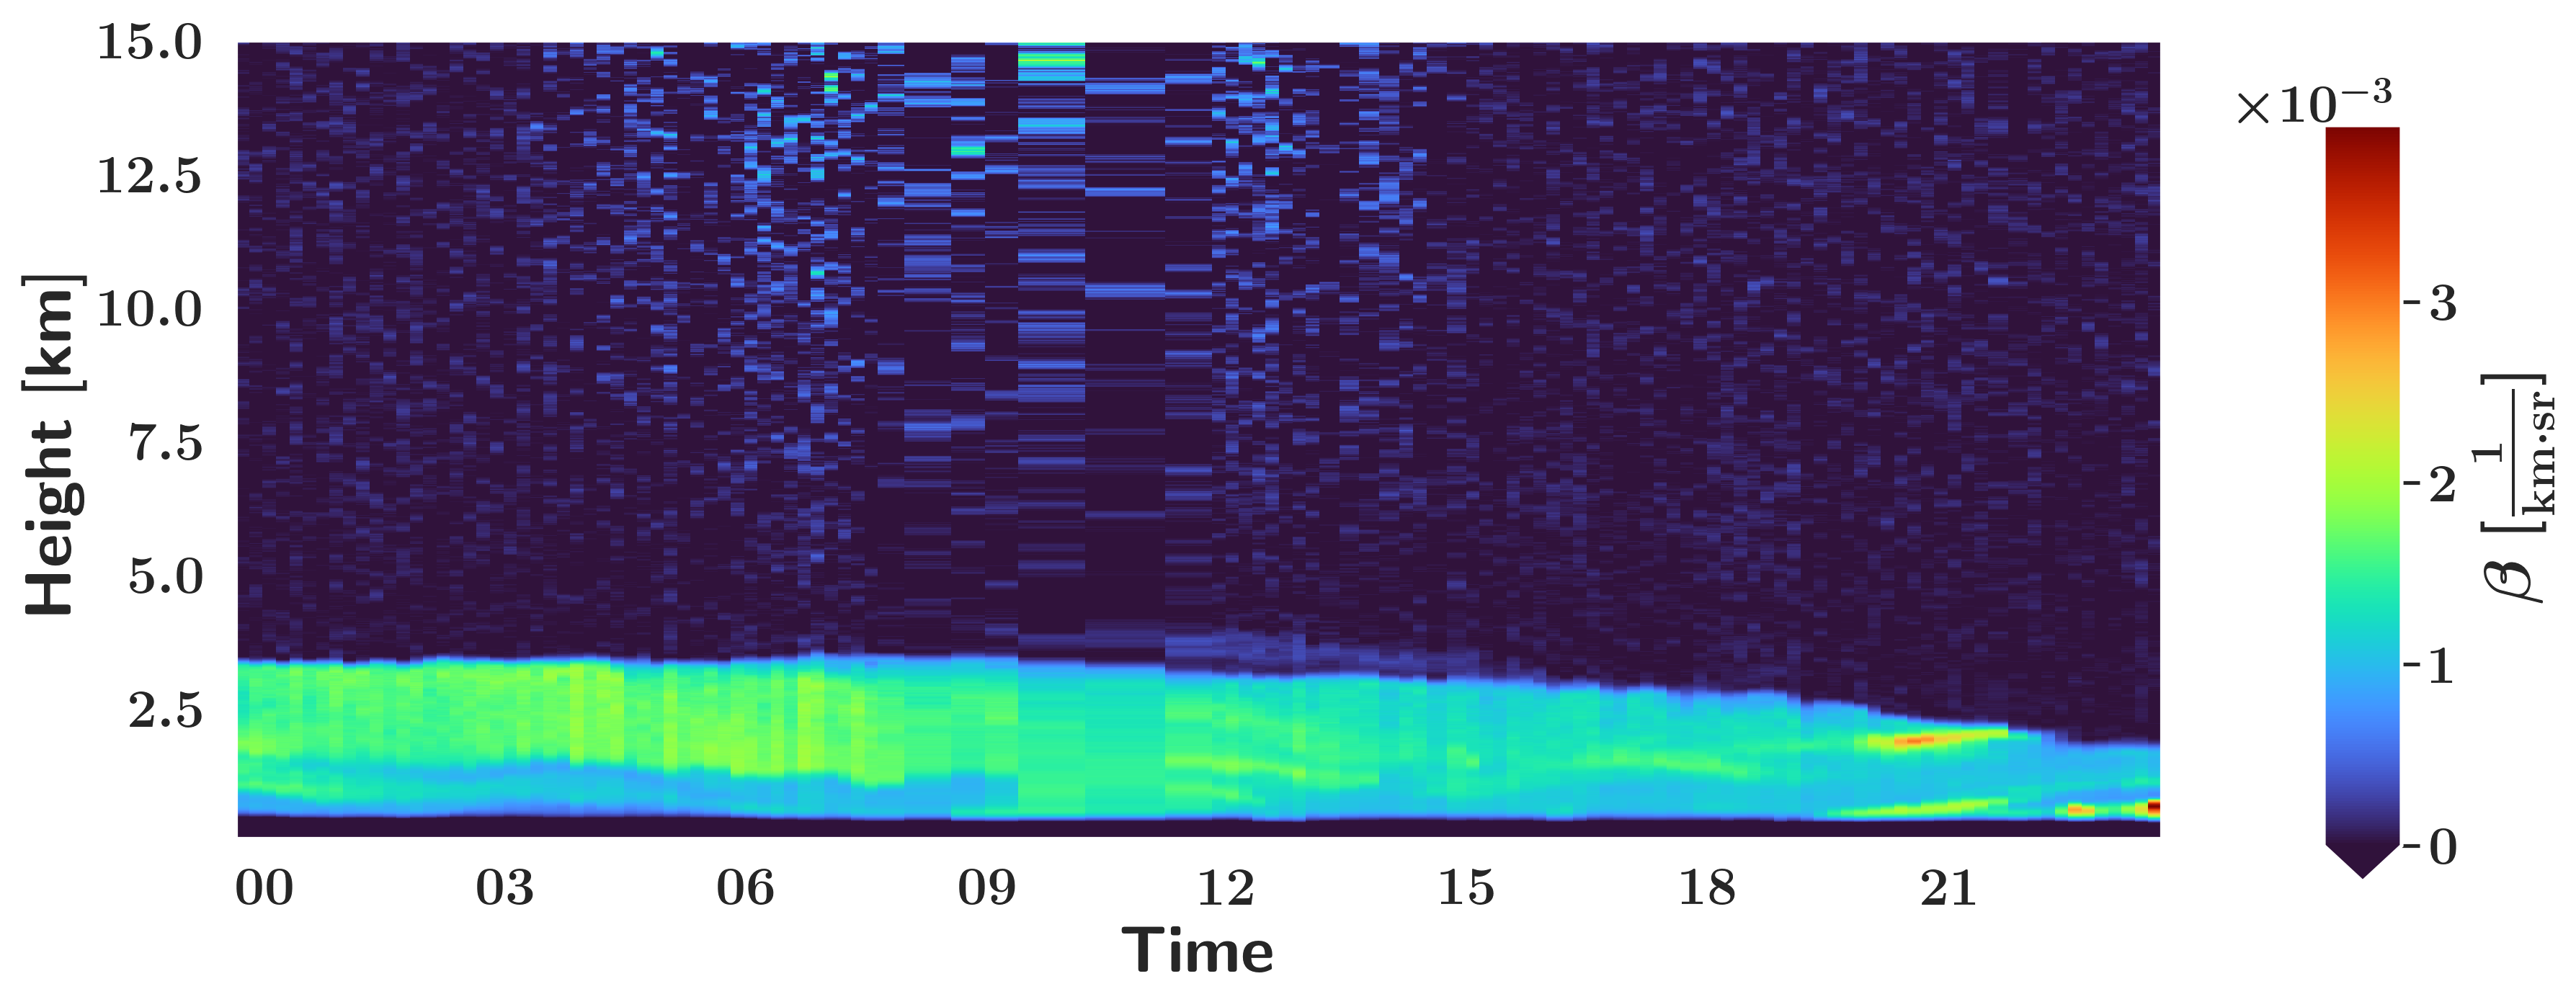

(None,
 <Figure size 3600x1500 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [7]:
plot_daily_profile_for_Opex(daily_beta_chan.sel(Time=valid_times).beta,
                            height_slice=height_slice,#, threshold= 2.5e-3 )
                            figsize=(12,5),save_fig=SAVE_FIG,
                            folder_name=figs_folder, format_fig=FORMAT_FIG)

### 5. Set and apply ratio to remove nonsense values, e.g., due to sun scatter.
### In addition removing negative values. Note that beta ratio will be used as weights for sampling, therefore, values must be positive.

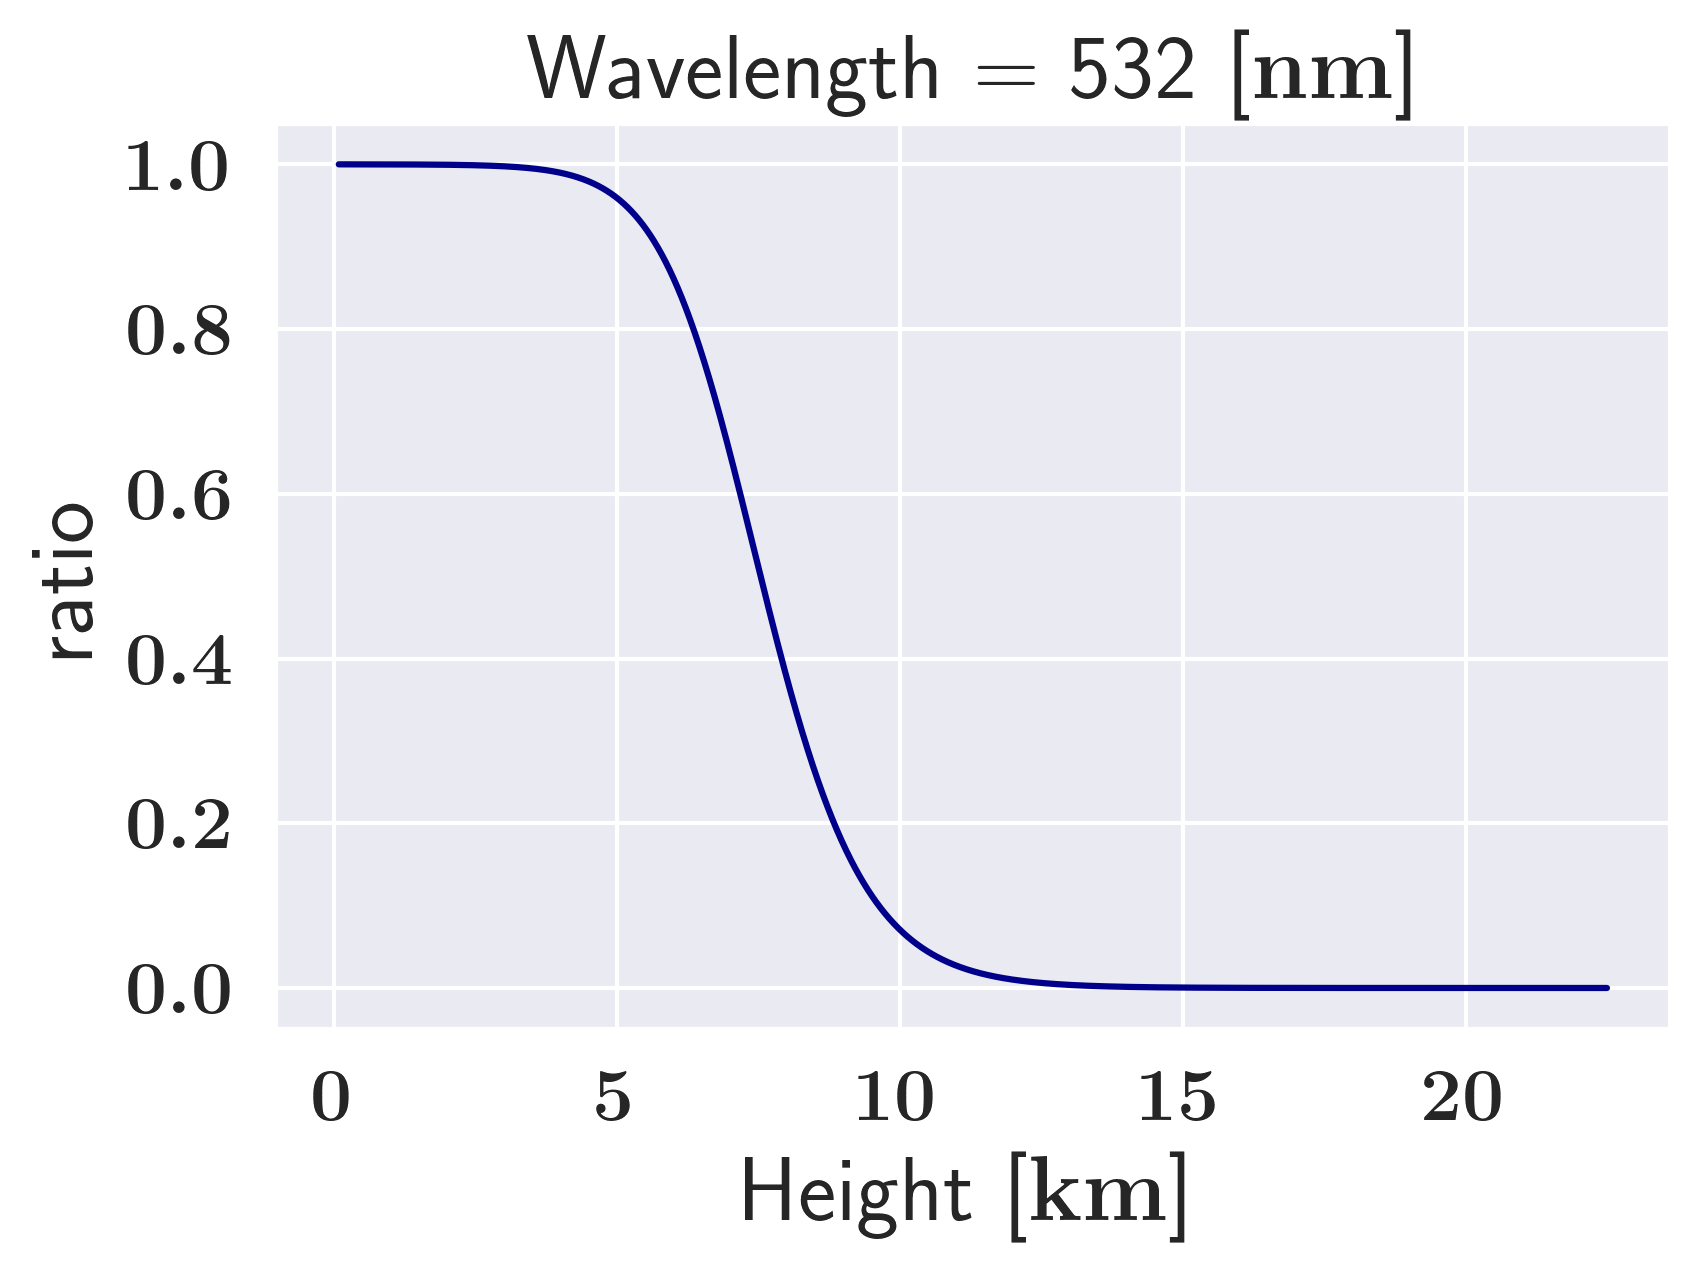

C:\Users\addalin\AppData\Local\Temp\ipykernel_6140\1513445115.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


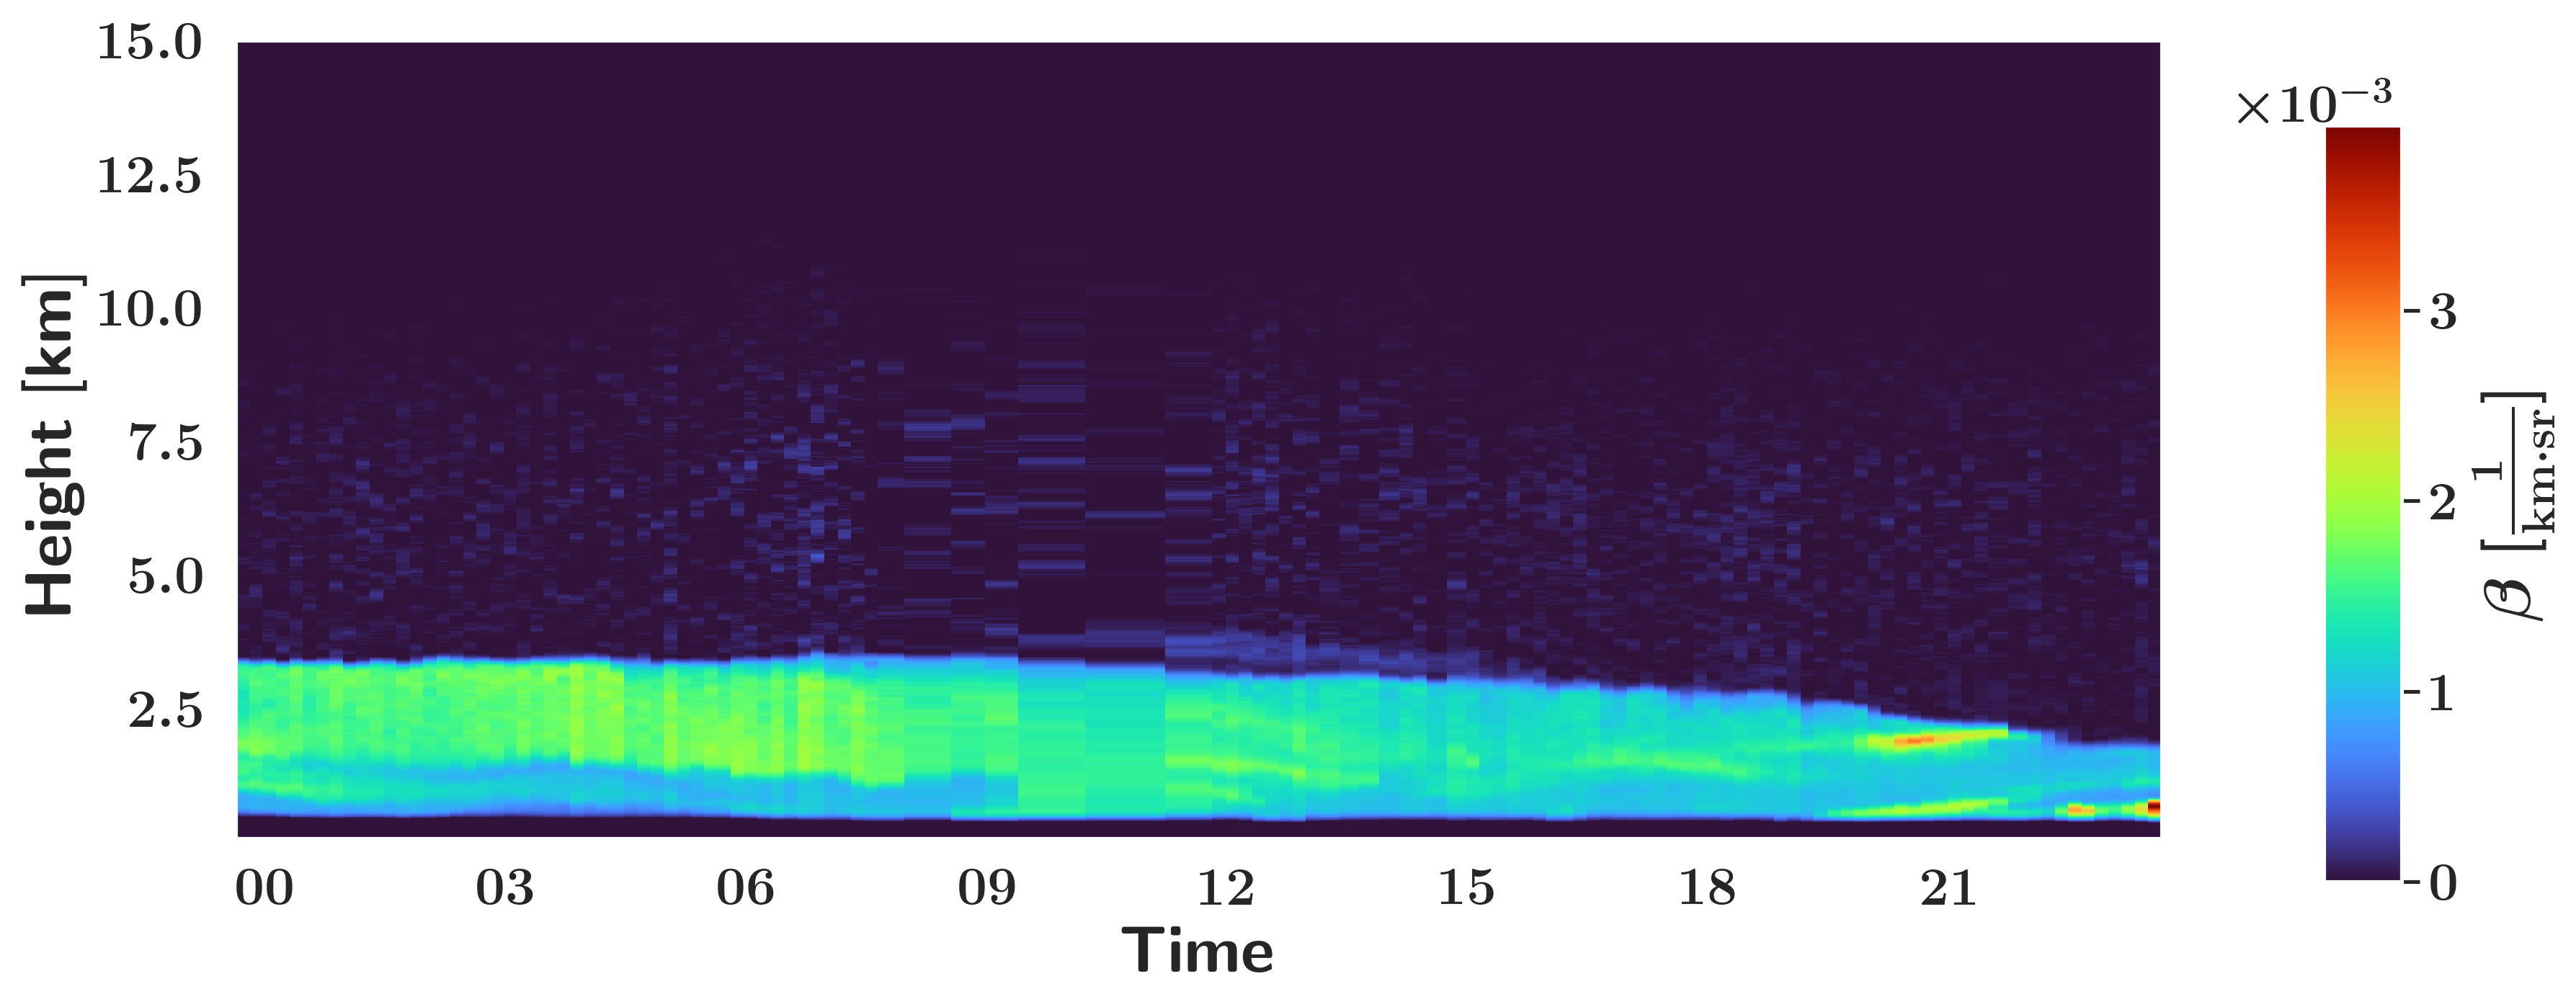

Range of backscatter coefficients in heights of slice(0, 15, None)[km] for orig beta:[-0.0016, 0.0040], after ratio: [0.0000, 0.0040]


In [8]:
sub_beta= daily_beta_chan.sel(Time=valid_times)

if GEN_PROFILES:
    # Set ratio
    ratio = xr.apply_ufunc(lambda x :gen_utils.sigmoid(daily_beta_chan.Height,x0=7,A=2,v=1.5)-1,
                           daily_beta_chan.Height, keep_attrs=True).\
        broadcast_like(sub_beta.beta).assign_attrs({'info': "Height-dependent ratio to apply on backscatter to reduce nonsense values",
                                                                  'name': 'ratio'})
    # Apply ratio
    beta_ratio = xr.apply_ufunc(lambda x,ratio: x*ratio,
                                sub_beta.beta.clip(min = gs.eps),
                                ratio,keep_attrs=True).fillna(gs.eps)
    beta_ratio.attrs['info']+=' - followed by ratio to reduce nonsense values.'
    # Add data arrays to  daily_beta_chan and save
    daily_beta_chan = daily_beta_chan.assign(beta_ratio=beta_ratio, ratio=ratio)
    xr_utils.save_dataset(dataset=daily_beta_chan,folder_name=TGRS_folder,nc_name=profiles_ds_name)
else:
    ratio = daily_beta_chan.ratio
    beta_ratio = daily_beta_chan.sel(Wavelength = wavelength).beta_ratio

# Plot ration and bet_ratio
ratio.mean(dim='Time').plot()
plt.show()
plot_daily_profile_for_Opex(beta_ratio.sel(Time=valid_times),height_slice=height_slice,
                            figsize=(12,5),save_fig=SAVE_FIG,
                            folder_name=figs_folder, format_fig=FORMAT_FIG)


print(f"Range of backscatter coefficients in heights of {height_slice}[km] for orig beta:"
      f"[{sub_beta.sel(Height= height_slice).beta.min().item():.4f}, {sub_beta.sel(Height= height_slice).beta.max().item():.4f}], "
      f"after ratio: [{beta_ratio.sel(Height= height_slice).min().item():.4f}, {beta_ratio.sel(Height= height_slice).max().item():.4f}]")

### 6. plot histogram

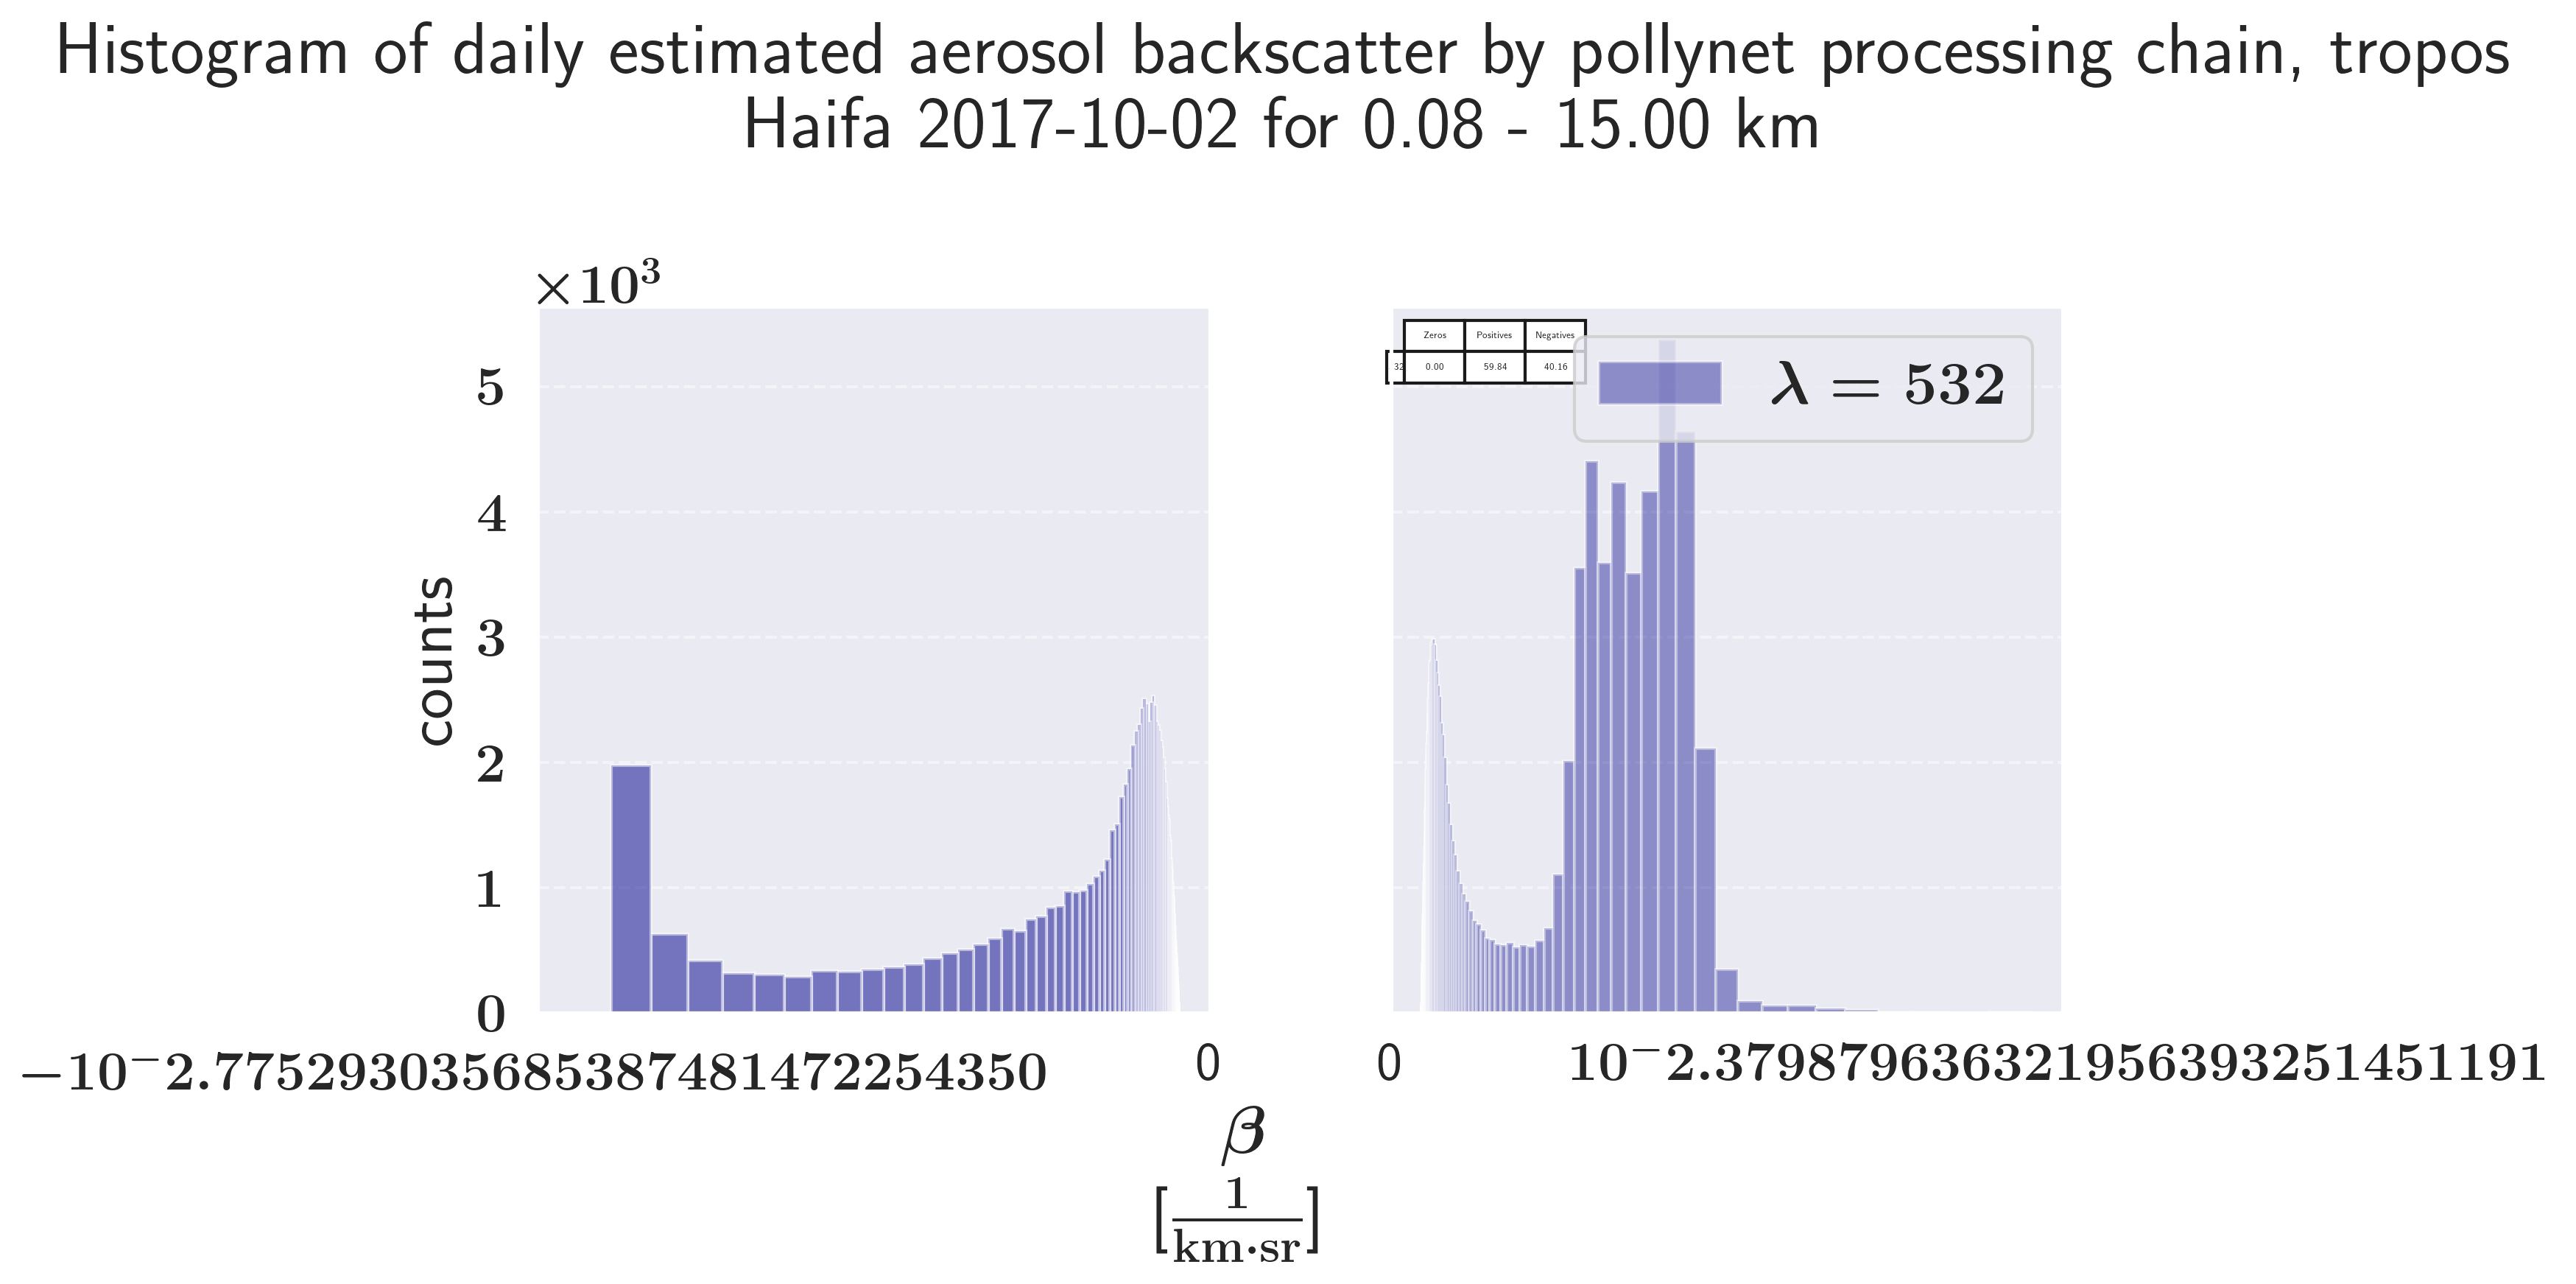

(<Figure size 3600x1800 with 2 Axes>,
 array([[<AxesSubplot:xlabel='$\\beta $\n[$\\rm \\frac{1}{km \\cdot sr}$]', ylabel='counts'>,
         <AxesSubplot:>]], dtype=object),
 [<xarray.Dataset>
  Dimensions:     (Wavelength: 1, Type: 3, Stats: 3)
  Coordinates:
    * Stats       (Stats) <U8 'zero' 'positive' 'negative'
    * Wavelength  (Wavelength) int32 532
  Dimensions without coordinates: Type
  Data variables:
      stats       (Wavelength, Type) object '0.00' '59.84' '40.16'
      index       int32 0
      start_time  datetime64[ns] 2017-10-02T00:04:30
      end_time    datetime64[ns] 2017-10-02T23:54:30],
 None)

In [9]:
vis_utils.daily_ds_histogram(daily_beta_chan.sel(Time=valid_times), profile_type='beta',
                       SAVE_FIG=SAVE_FIG, n_temporal_splits=1,
                       nbins=200, figsize=(12, 6), height_range= height_slice,
                       dst_folder=os.path.join(os.path.abspath(os.curdir), 'figures'),
                       format_fig=FORMAT_FIG)

### 6. Time interpolated backscatter

C:\Users\addalin\AppData\Local\Temp\ipykernel_6140\1513445115.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .87, 1])


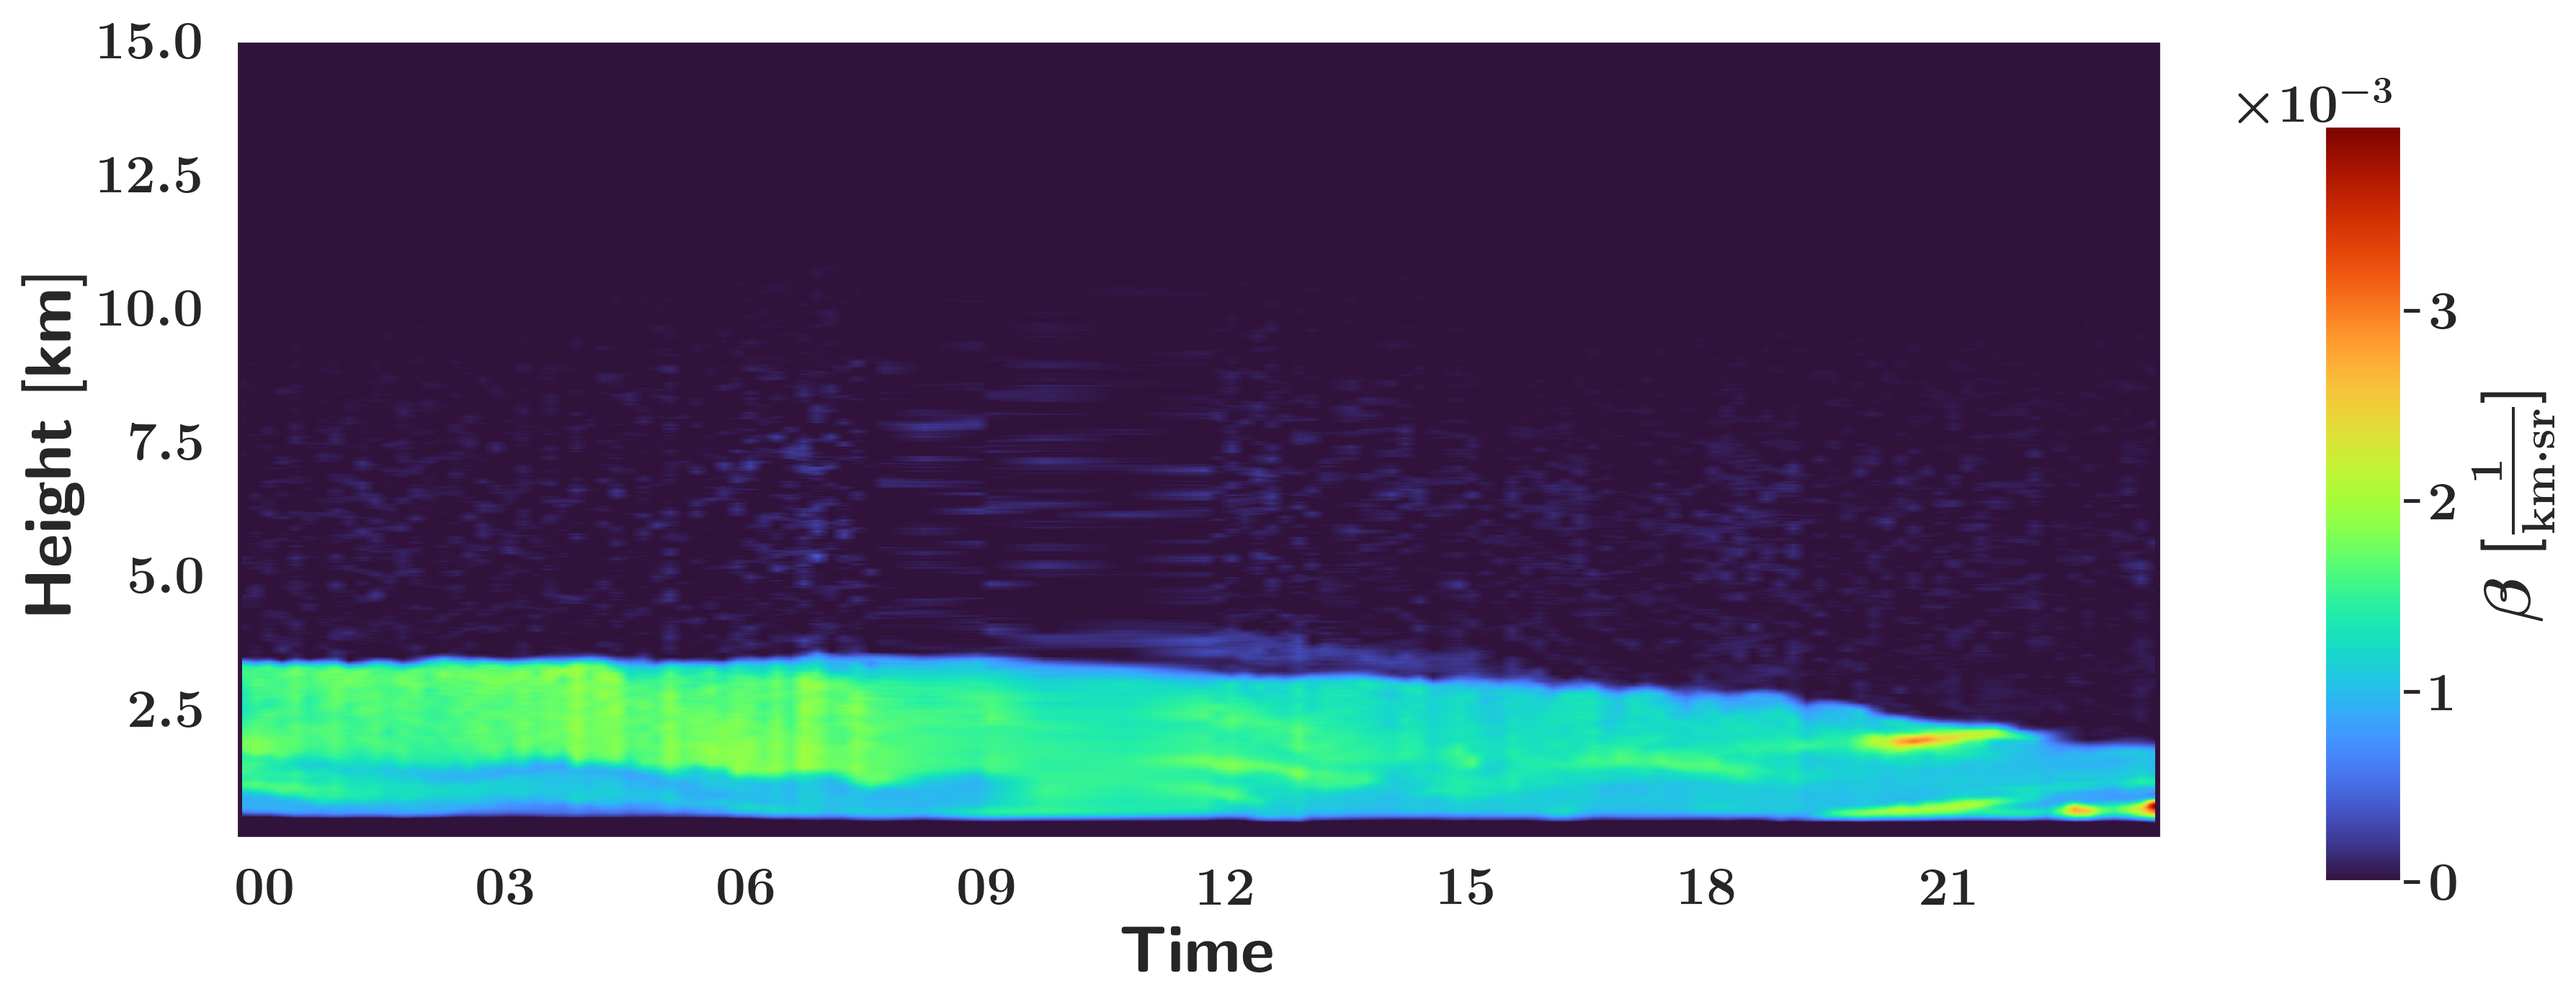

(None,
 <Figure size 3600x1500 with 2 Axes>,
 <AxesSubplot:xlabel='\\textbf{Time}', ylabel='\\textbf{Height} [$\\rm \\textbf{km}$]'>)

In [10]:
if GEN_PROFILES:
    interp_beta =  beta_ratio.interp(Time=daily_times).fillna(0.0) # sub_beta.beta.interp(Time=daily_times).fillna(0.0)
    interp_beta.attrs['info'] = 'Time interpolation of estimated aerosol backscatter profiles by PollyNet Processing Chain, Tropos'
    daily_beta_chan = daily_beta_chan.assign(interp_beta=interp_beta)
    xr_utils.save_dataset(dataset=daily_beta_chan,folder_name=TGRS_folder,nc_name=profiles_ds_name)
else:
    interp_beta = daily_beta_chan.interp_beta


plot_daily_profile_for_Opex(daily_beta_chan.interp_beta,height_slice=height_slice,
                            figsize=(12,5),save_fig=SAVE_FIG,
                            folder_name=figs_folder, format_fig=FORMAT_FIG)


### 7. Plot contours

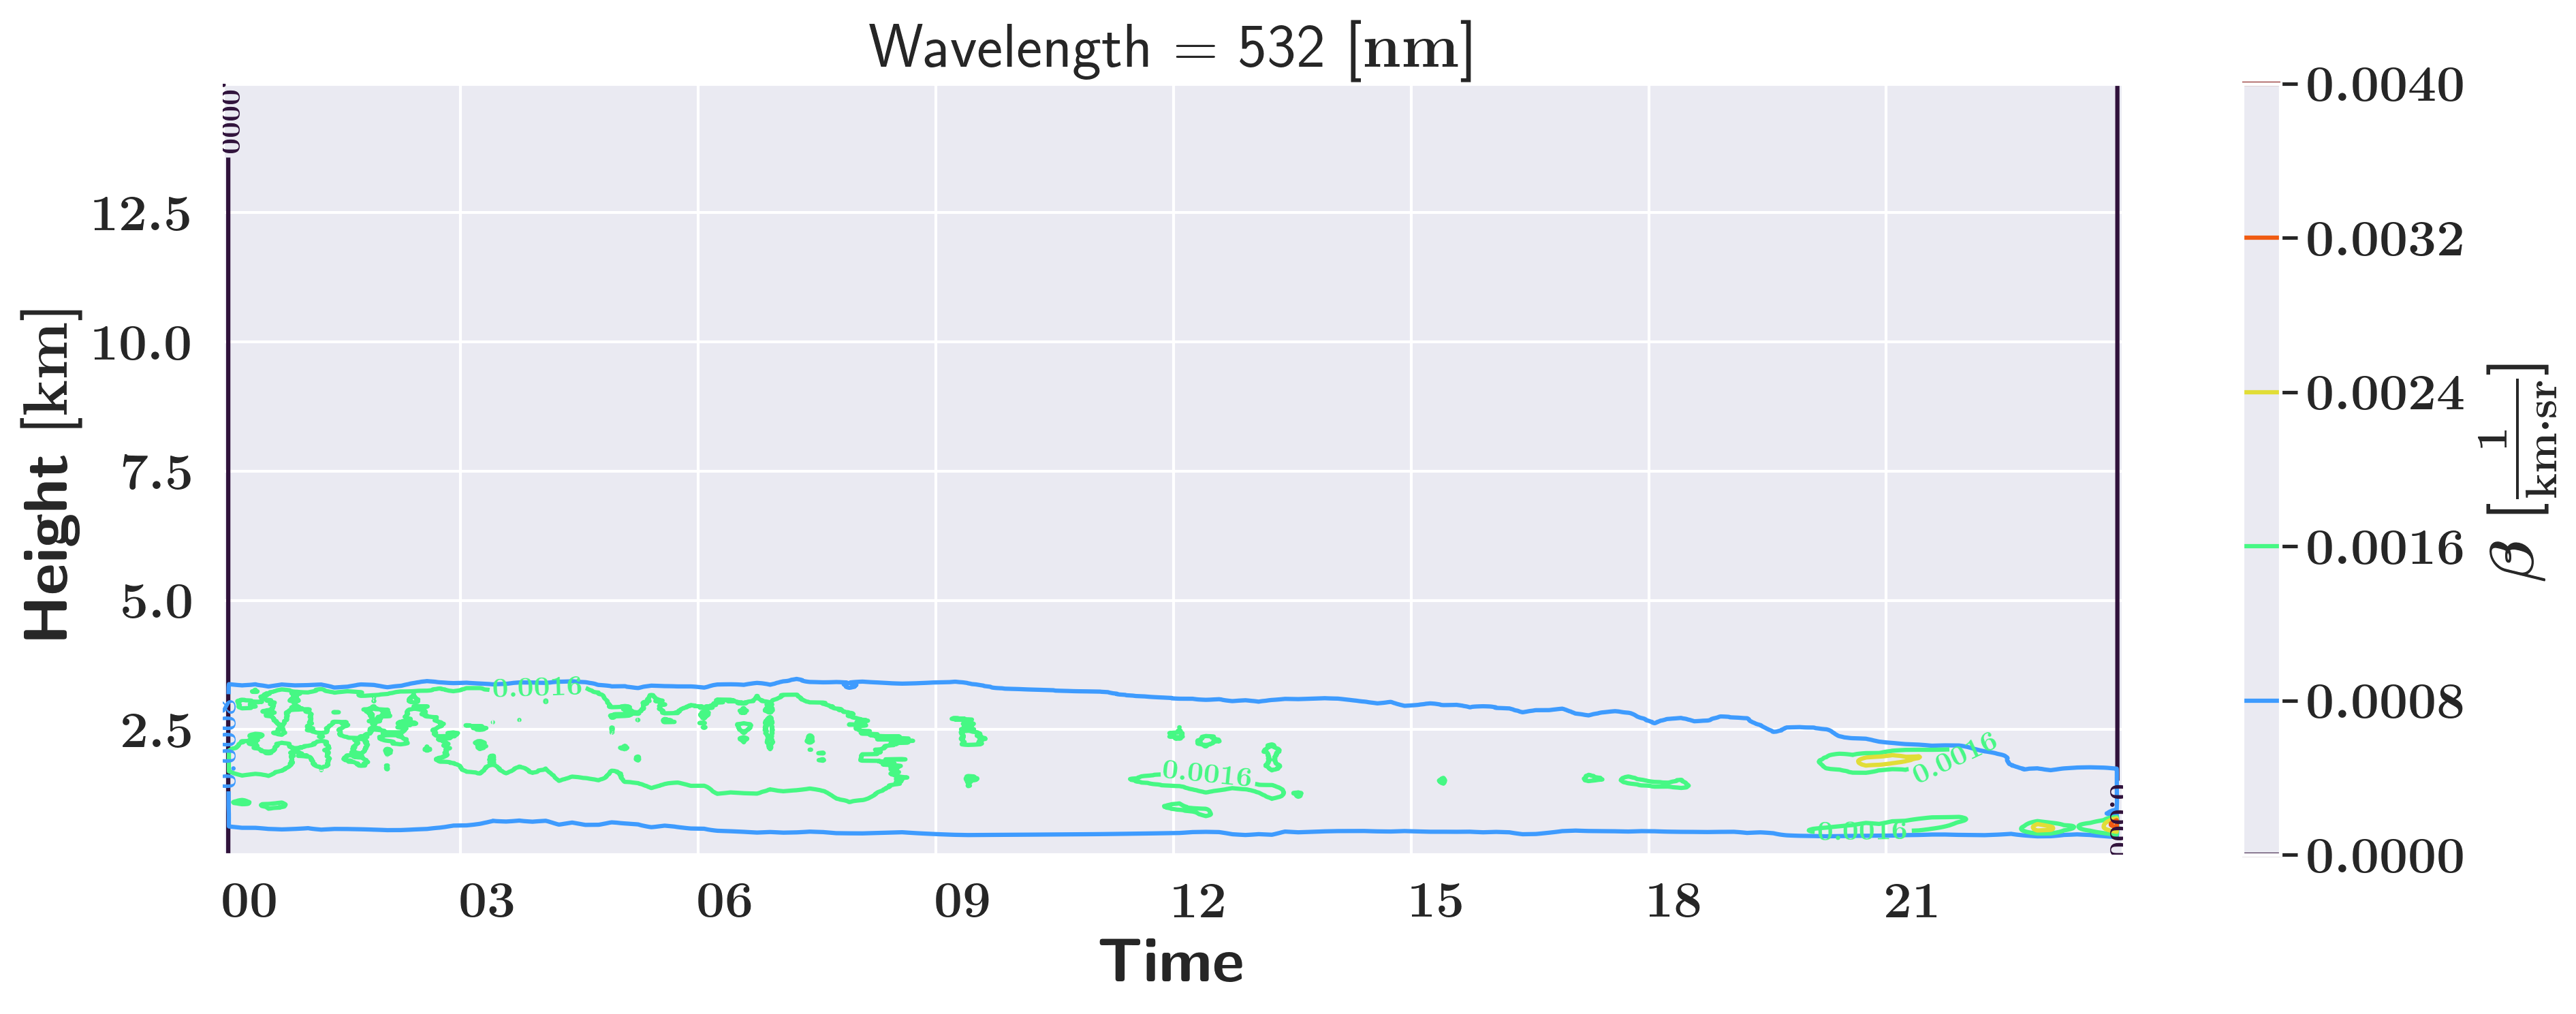

Num levels =6  at values: [0.     0.0008 0.0016 0.0024 0.0032 0.004 ]


In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15, 5))
CS = xr.plot.contour(daily_beta_chan.sel(Wavelength = 532, Height=slice(0,15)).interp_beta,
                add_labels = True, add_colorbar =True, ax= ax,cmap= 'turbo')
ax.clabel(CS, inline=True, fontsize=10)
ax.set_rasterization_zorder(-10)
ax.xaxis.set_major_formatter(TIMEFORMAT)
ax.xaxis.set_tick_params(rotation=0)
#
ax.set_ylabel(ax.get_ylabel().replace("Height", r'\textbf{Height}'))
ax.set_xlabel(ax.get_xlabel().replace("Time", r'\textbf{Time}'))
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
if SAVE_FIG:
    #if folder_name is None:
    folder_name = figs_folder #os.path.join(os.path.abspath(os.path.curdir),'figures')
    stitile = f"Contours of beta for {day_date.strftime('%Y-%m-%d')}"
    fig_path = vis_utils.save_fig(fig, fig_name=stitile,
                                       folder_name=folder_name,
                                       format_fig=FORMAT_FIG)
plt.show()
levels = CS.levels
print(f"Num levels ={len(levels)}  at values: {levels}")

In [12]:
min_vals = levels[0:-1][0::1]
max_vals = min_vals[1::1].tolist()
max_vals.append(daily_beta_chan.sel(Wavelength = 532, Height=slice(0,15) ).interp_beta.max().item())
min_vals, max_vals

(array([0.    , 0.0008, 0.0016, 0.0024, 0.0032]),
 [0.0008, 0.0016, 0.0024000000000000002, 0.0032, 0.003970980644226074])

In [13]:
def sample_level(X:np.ndarray,Y:np.ndarray, weights:np.ndarray, n_iter=10,  total_samples = 10000):
    # estimate xy samples
    weight_vector = weights.values.reshape(X.size)
    XY= np.vstack([X.reshape(X.size), Y.reshape(X.size)])
    print(weight_vector.shape)
    sampels_per_iter = round(total_samples/n_iter)
    XY_s = []
    for n_samples in range(n_iter):
        # Sample indexes of (x,y) locations according to weight vector

        inds = random.choices(population=np.arange(weight_vector.shape[0]),  # list to pick from
                              weights=weight_vector,  # weights of the population, in order
                              k=sampels_per_iter,  # amount of samples to draw

        )
        inds.sort()
        XY_s.append(XY[:,inds])

    XY_samples = np.concatenate(XY_s, axis=1)

    # Show samples
    plt.scatter(XY_samples[0], XY_samples[1], s=.1)
    plt.show()

    # Show 2D histogram
    d_x = X[0,1] - X[0, 0]
    d_y = Y[1,0] -Y[0, 0]

    edges_x = X[0,:]+.5*d_x
    edges_y = Y[:,0]+.5*d_y
    edge0_x = np.array(X[0, 0]-.5*d_x).reshape(1)
    edge0_y = np.array(Y[0, 0]-.5*d_y).reshape(1)
    edges_x = np.append(edge0_x,edges_x,axis=0)
    edges_y = np.append(edge0_y,edges_y,axis=0)
    H, yedges, xedges = np.histogram2d(XY_samples[0], XY_samples[1], bins=(edges_x, edges_y))
    kernel_weights_da = xr.DataArray(data=H.T,coords={'y':Y[:,0], 'x':X[0,:]},attrs={'long_name':r'$N_s$'})
    kernel_weights_da.plot(cmap='turbo')
    plt.show()

    return XY_samples, kernel_weights_da

### 8. Set grid for sampling $\beta$ after ratio

In [14]:
#scaling time dimension, since the BW currently is equal to both dimensions (in sklearn, not sure regardig scipy)
SCALE_TIME = True
if SCALE_TIME:
    bw_height = 0.1# [km]
    bw_time = 300 # [sec] --> 10 min = 600 sec
    scale_time = bw_time/bw_height
else:
    scale_time = 1.0
    bw_height =''
    bw_time =''

beta_ratio.sel(Time=valid_times)
# Set xy samples locations:
y = daily_beta_chan.sel(Height= slice(0,max_height)).Height.values
x = np.array([(t-day_date).seconds for t in valid_times])/scale_time

X,Y = np.meshgrid(x, y, indexing='xy')
XY_orig = np.vstack([X.reshape(X.size), Y.reshape(X.size)])

In [15]:
### 9. Get samples from $\beta$

(243756,)


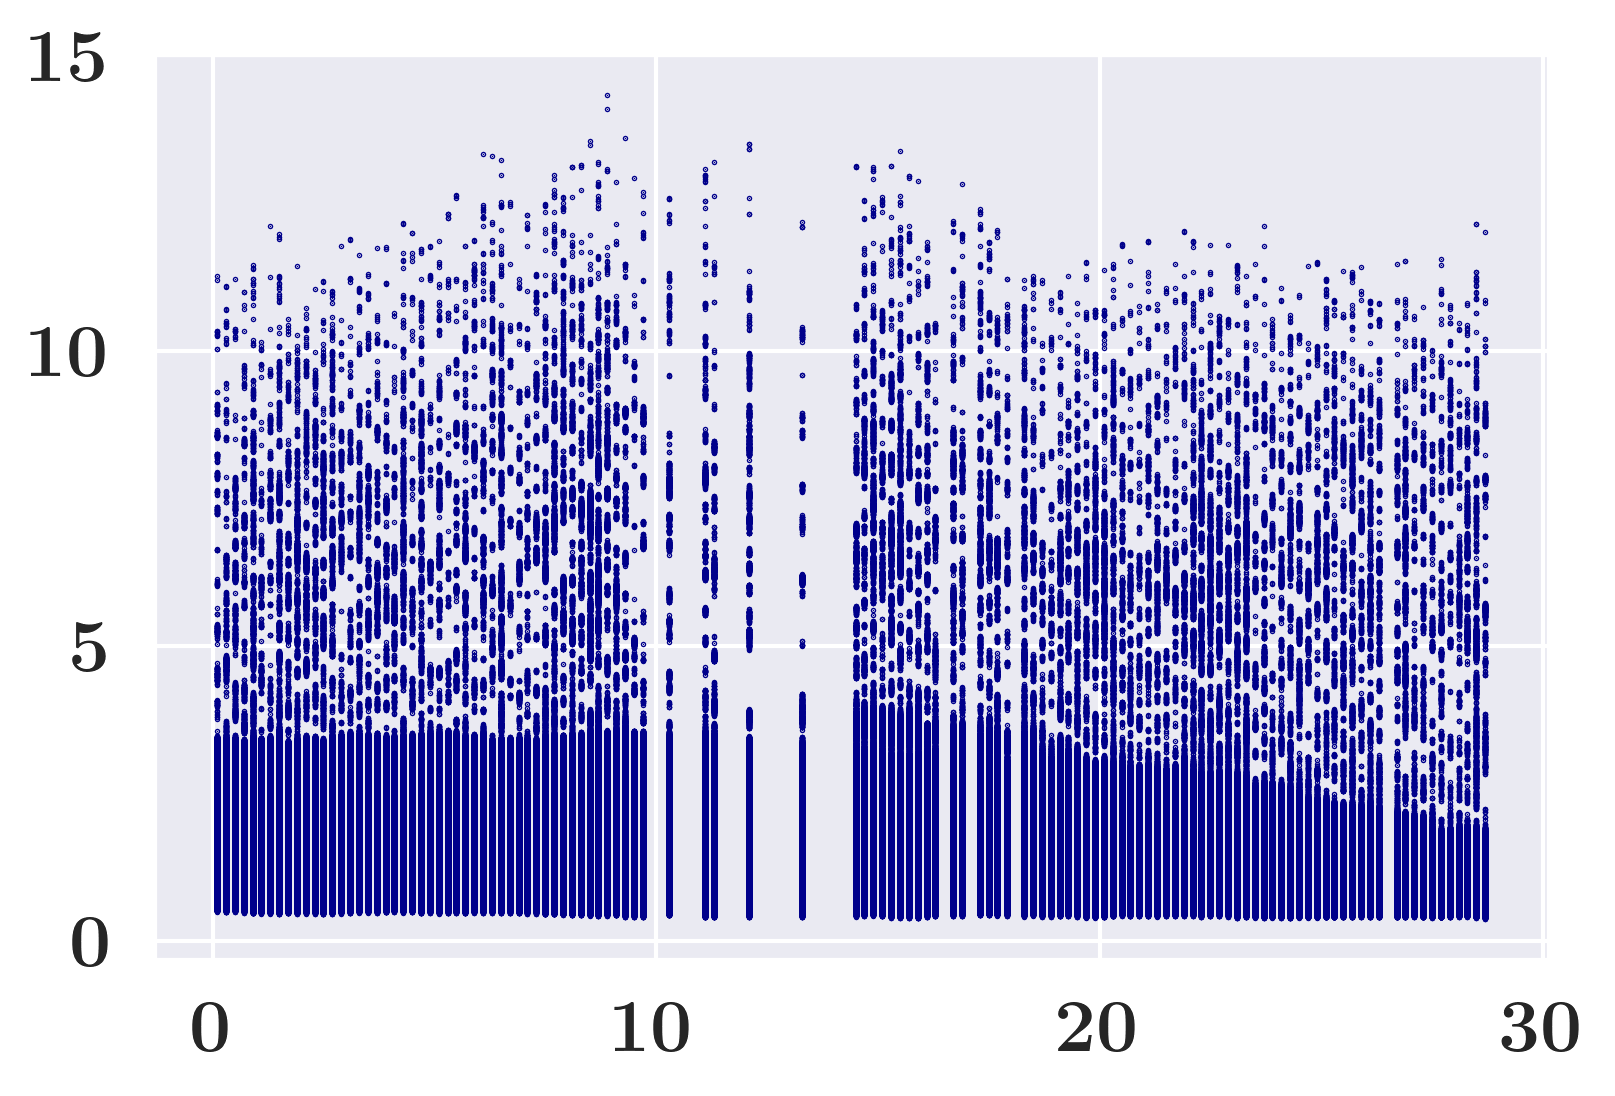

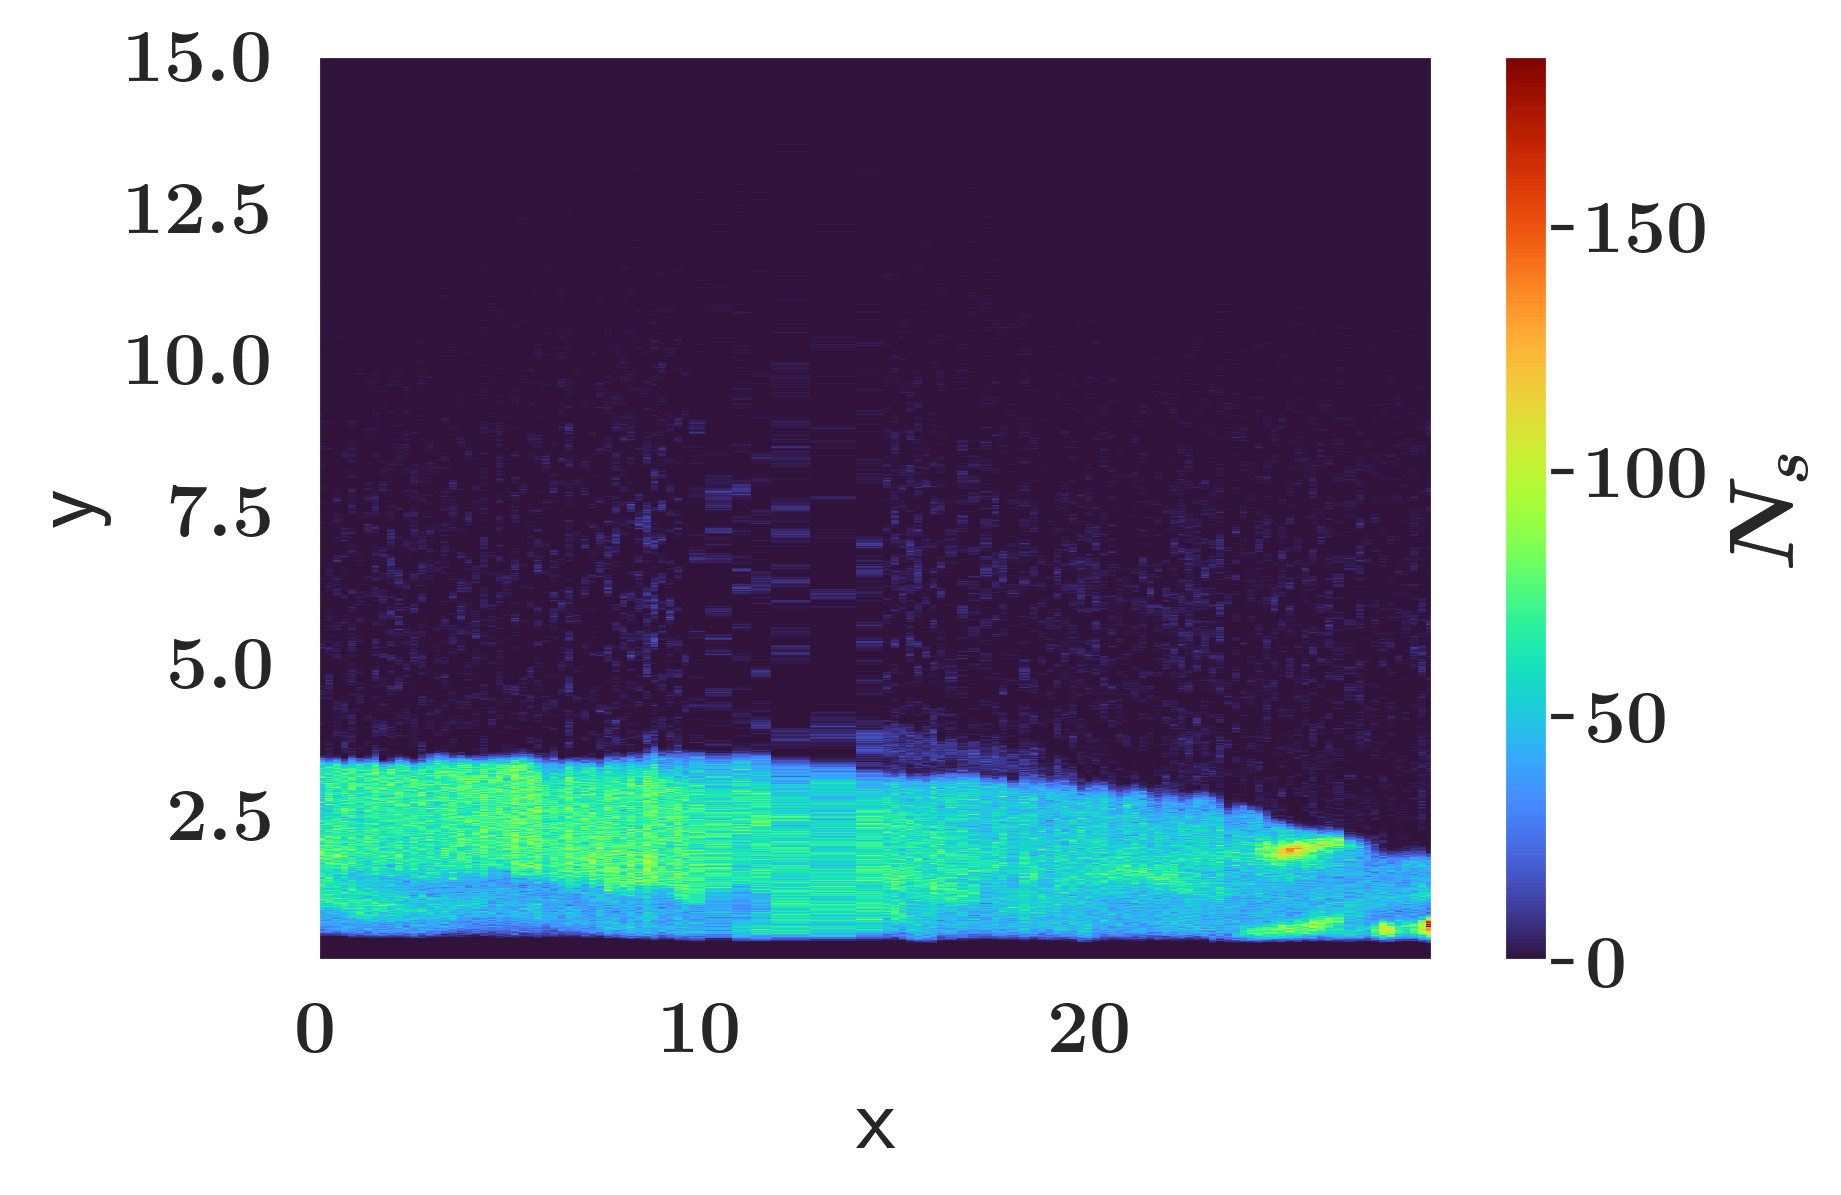

In [16]:
total_samples = len(valid_times)*len(y)*10
n_iter = len(valid_times)*10
samples, hist_2D = sample_level(X,Y, beta_ratio.sel(Time=valid_times,Height= slice(0,max_height)), n_iter=n_iter,  total_samples = total_samples)

### 10. Aplly GMM

In [ ]:
gmm = BayesianGaussianMixture(n_components=31,covariance_type="full",verbose=2,
                              tol=0.0001,reg_covar= 1e-7,max_iter=600, # increase max_iter
                              n_init=1,  init_params='k-means++') # mean_prior=(X[0,:].mean(),0.2)) # "tied", "diag", "full"

print('Start GMM fit')
tic_fit=TicToc()
tic_fit.tic()
gmm.fit(samples.T)
tic_fit.toc()

Start GMM fit
Initialization 0
  Iteration 10	 time lapse 114.15073s	 ll change 9778.82403
  Iteration 20	 time lapse 103.78045s	 ll change 9372.55392
  Iteration 30	 time lapse 105.82303s	 ll change 8948.34703


### 11. Calculate log-liklihood scores on the grid

In [ ]:
print('calculate log-likelihood on the grid')
tic_score=TicToc()
tic_score.tic()
z = gmm.score_samples(XY_orig.T) # Note that this method returns log-likelihood
z = np.exp(z) # e^x to get likelihood values
z = z.reshape(X.shape)
tic_score.toc()
#beta_max = weights.max().item()-weights.min().item()
new_beta = proc_utils.normalize(z.copy())
img = ax.contourf(x, y, new_beta, 100, cmap="turbo")
n_cols = 1
n_rows = 1
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(img, cax=cax, orientation='vertical')
plt.show()